# Análisis Exploratorio de Datos (EDA) para Predicción de Compensación Total

In [39]:
# Importo las bibliotecas necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os

En esta sección, realizo un análisis exploratorio inicial de los datos recopilados de las encuestas de **Stack Overflow** de los años 2023 y 2024. El objetivo principal es entender la distribución de la variable objetivo, *CompTotal*, que representa la compensación total anual de los encuestados en España. Este análisis permite identificar patrones generales, diferencias entre los conjuntos de datos y posibles desafíos para el modelado, como distribuciones sesgadas o valores extremos.

In [40]:
# Establecer la opción para mostrar todas las columnas
pd.set_option('display.max_columns', None)

In [41]:
# Carga los datasets de 2023 y 2024
sof_23 = pd.read_csv('../data/survey_results_public23.csv')
sof_24 = pd.read_csv('../data/survey_results_public.csv')

## Filtrado de datos para mantener solo los encuestados que:
- Residen en España ('Country' == 'Spain')
- Tienen un valor no nulo en 'CompTotal' (la columna objetivo del proyecto)

In [42]:
# Dataset de 2023
data_2023 = sof_23[(sof_23['Country'] == 'Spain') & sof_23['CompTotal'].notna()]
data_2023.reset_index(drop=True, inplace=True) # Reinicia los índices para mayor claridad
data_2023 = data_2023.drop(columns=['ResponseId']) # Elimina la columna innecesaria 'ResponseId'

In [43]:
# Hago lo mismo, pero con el dataset de 2024
data_2024 = sof_24[(sof_24['Country'] == 'Spain') & sof_24['CompTotal'].notna()]
data_2024.reset_index(drop=True, inplace=True)
data_2024 = data_2024.drop(columns=['ResponseId'])

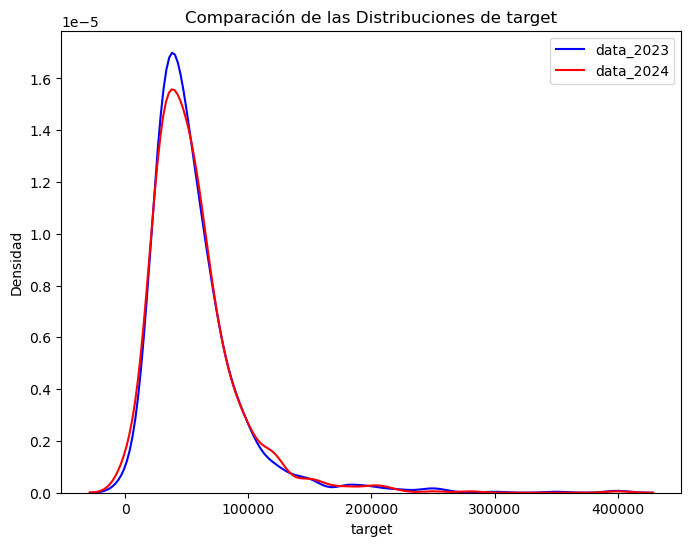

In [44]:
# Visualización combinada de las distribuciones de 'CompTotal'
plt.figure(figsize=(8, 6))  # Configura el tamaño del gráfico
sns.kdeplot(data_2023['CompTotal'], label='data_2023', color='blue')  # Curva KDE para data_2023
sns.kdeplot(data_2024['CompTotal'], label='data_2024', color='red')   # Curva KDE para data_2024
plt.title('Comparación de las Distribuciones de target')  # Título del gráfico
plt.xlabel('target')  # Etiqueta del eje X
plt.ylabel('Densidad')  # Etiqueta del eje Y
plt.legend()  # Muestra la leyenda para identificar cada curva
plt.show()  # Muestra el gráfico

Interpretación del Gráfico:
- Similitud General: Las dos curvas son muy similares en su forma general. Ambas muestran una distribución asimétrica positiva (sesgada a la derecha), con un pico principal alrededor de un valor cercano a 50,000 y una cola que se extiende hacia valores más altos.
- Diferencias Ligeras: Hay algunas diferencias sutiles:
    - Pico Principal: El pico de data_2023 parece ser ligeramente más alto y estrecho que el de data_2024. Esto sugiere que los valores de "target" en data_2023 están un poco más concentrados alrededor de la moda (el valor más frecuente).
    - Cola Derecha: La cola derecha de data_2024 parece ser un poco más gruesa que la de data_2023. Esto indica que hay una proporción ligeramente mayor de valores altos (relativamente hablando) en data_2024 en comparación con data_2023.
    - Entre 100000 y 200000: Se puede observar una diferencia ligera pero notoria, en donde la densidad de data_2024 en ese intervalo, es mayor que la de data_2023.
- Combinaré los dos DataFrames para mi modelo, ya que las distribuciones de la variable "target" son lo suficientemente similares como para que un modelo pueda aprender patrones comunes de ambos conjuntos de datos.

## Limpieza de Datos: Preparación para el Modelo
En esta sección, se abordan las transformaciones y correcciones necesarias para garantizar la consistencia y la calidad de los datos. 

Se identifican valores atípicos, errores en la interpretación de las respuestas, y se realizan ajustes para estandarizar la variable *CompTotal*, que representa la compensación total anual.

### Explicación General del Proceso de Limpieza
1. Identificación de Valores Atípicos y NAN "Enmascarados"
- Se eliminan valores nulos representados como 0 en la columna CompTotal, ya que no aportan información útil para el análisis.
2. Corrección de Errores de Escala
- Se identifican y corrigen casos donde los encuestados parecen haber omitido ceros en sus respuestas (36, 68, 400 se transforman a 36000, 68000, 400000).
- Se ajustan valores anómalos reportados como compensación mensual multiplicándolos por 12 para convertirlos a escala anual.
3. Eliminación de Muestras Inconsistentes
- Se eliminan registros con inconsistencias claras, como valores irreales en relación con la edad, experiencia y nivel educativo.
4. Verificación de Ingresos Altos
- Se examinan los registros con compensaciones mayores a 200k. Los valores encontrados reflejan casos plausibles, por lo que se retienen en el conjunto de datos.
5. Exportación de Datos Limpios
- Los conjuntos de datos finales, *data_2023* y *data_2024*, se exportan utilizando *pickle* para garantizar su reutilización en los siguientes pasos del proyecto.

### Comienzo con la limpieza del data_2023

In [45]:
# Eliminación de valores de compensación total igual a 0, que no aportan información relevante.
data_2023 = data_2023.loc[data_2023['CompTotal'] != 0]

# Ordena los valores de la columna 'CompTotal' para detectar valores inusualmente bajos o altos.
target23 = data_2023['CompTotal']
target23.sort_values()

72          23.0
1137        36.0
305         40.0
476         60.0
1052      1600.0
          ...   
988     260000.0
760     300000.0
324     350000.0
90      400000.0
852     400000.0
Name: CompTotal, Length: 1151, dtype: float64

Se observaron valores inusualmente bajos (23, 40, 60, 36) en la columna 'CompTotal'. Se asume que estos valores representan miles (23k, 40k, 60k, 36k) y que los encuestados omitieron los tres ceros finales, probablemente por simplicidad o costumbre. Esta interpretación se alinea con la naturaleza de la pregunta (compensación anual) y es consistente con los valores más comunes dentro de la misma columna. Para mantener la consistencia y la escala adecuada en los datos, se multiplican estos valores por 1000. Esta decisión se basa en un criterio de coherencia interna de los datos y el contexto de la encuesta. Se prioriza una interpretación lógica y una posible corrección de un error de ingreso de datos, sobre la eliminación de estos registros valiosos para el analisis

In [46]:
# Lista de valores erróneos detectados
valores_a_multiplicar = [23, 40, 60, 36]

# Multiplica los valores erróneos por 1000 para corregirlos.
data_2023.loc[data_2023['CompTotal'].isin(valores_a_multiplicar), 'CompTotal'] *= 1000

Se identificaron valores en la columna 'CompTotal' en el rango de 1600 a 4000 euros. Dado que la pregunta solicitaba la compensación total anual, y considerando que un salario mensual en este rango es plausible, mientras que un salario anual de esta cantidad es improbable, se asume que los encuestados que reportaron estos valores proporcionaron su salario mensual en lugar del anual. Para corregir este error y alinear estos valores con la escala del resto de los datos, se multiplicaron los valores en el rango 1500-4000 por 12. Esta corrección se basa en la presunción de un error sistemático en la interpretación de la pregunta por parte de un subconjunto de los encuestados

In [47]:
# Los valores entre 1600 y 4000 son multiplicados por 12 para ajustarlos a la escala anual.
valores_a_multiplicar = [1600, 1950, 3800, 4000]

# Multiplica por 12 para corregir los valores a escala anual.
data_2023.loc[data_2023['CompTotal'].isin(valores_a_multiplicar), 'CompTotal'] *= 12

# Muestra estadísticas descriptivas para validar los ajustes realizados.
data_2023['CompTotal'].describe()

count      1151.000000
mean      56324.973067
std       38624.357696
min        8400.000000
25%       34000.000000
50%       46000.000000
75%       67000.000000
max      400000.000000
Name: CompTotal, dtype: float64

Verificación de Altos Ingresos

Se seleccionaron las muestras correspondientes a los encuestados que reportaron una compensación total anual ('CompTotal') superior a 200k. El objetivo fue examinar estos casos para determinar la presencia de posibles valores atípicos. Se encontró que, en su mayoría, los altos ingresos declarados están justificados por factores como una extensa experiencia profesional en el área y otros indicadores que sugieren la veracidad de los datos. En consecuencia, se concluye que estos valores, aunque altos, no se clasifican como atípicos, sino que reflejan una compensación acorde a circunstancias particulares de los encuestados.

In [48]:
# Identificación de valores altos (> 200k) para verificar su consistencia.
mask = data_2023['CompTotal'] > 200000
data_2023[mask]

,Q120,MainBranch,Age,Employment,RemoteWork,CodingActivities,EdLevel,LearnCode,LearnCodeOnline,LearnCodeCoursesCert,YearsCode,YearsCodePro,DevType,OrgSize,PurchaseInfluence,TechList,BuyNewTool,Country,Currency,CompTotal,LanguageHaveWorkedWith,LanguageWantToWorkWith,DatabaseHaveWorkedWith,DatabaseWantToWorkWith,PlatformHaveWorkedWith,PlatformWantToWorkWith,WebframeHaveWorkedWith,WebframeWantToWorkWith,MiscTechHaveWorkedWith,MiscTechWantToWorkWith,ToolsTechHaveWorkedWith,ToolsTechWantToWorkWith,NEWCollabToolsHaveWorkedWith,NEWCollabToolsWantToWorkWith,OpSysPersonal use,OpSysProfessional use,OfficeStackAsyncHaveWorkedWith,OfficeStackAsyncWantToWorkWith,OfficeStackSyncHaveWorkedWith,OfficeStackSyncWantToWorkWith,AISearchHaveWorkedWith,AISearchWantToWorkWith,AIDevHaveWorkedWith,AIDevWantToWorkWith,NEWSOSites,SOVisitFreq,SOAccount,SOPartFreq,SOComm,SOAI,AISelect,AISent,AIAcc,AIBen,AIToolInterested in Using,AIToolCurrently Using,AIToolNot interested in Using,AINextVery different,AINextNeither different nor similar,AINextSomewhat similar,AINextVery similar,AINextSomewhat different,TBranch,ICorPM,WorkExp,Knowledge_1,Knowledge_2,Knowledge_3,Knowledge_4,Knowledge_5,Knowledge_6,Knowledge_7,Knowledge_8,Frequency_1,Frequency_2,Frequency_3,TimeSearching,TimeAnswering,ProfessionalTech,Industry,SurveyLength,SurveyEase,ConvertedCompYearly
90,I agree,I am a developer by profession,35-44 years old,"Employed, full-time;Independent contractor, fr...","Hybrid (some remote, some in-person)",Hobby;Contribute to open-source projects;Profe...,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",Books / Physical media;On the job training;Oth...,Formal documentation provided by the owner of ...,NaN,20,15,"Senior Executive (C-Suite, VP, etc.)",20 to 99 employees,I have a great deal of influence,Investigate,Start a free trial;Ask developers I know/work ...,Spain,EUR European Euro,400000.0,C;C++;Erlang;Go;Haskell;JavaScript;Python;Rust...,C;Erlang;Haskell;Python;Rust;SQL,Clickhouse;InfluxDB;PostgreSQL;Redis;SQLite,PostgreSQL;Redis;SQLite,Amazon Web Services (AWS);Cloudflare;Digital O...,Amazon Web Services (AWS);Cloudflare;Digital O...,Django;FastAPI;Node.js;React,Django;FastAPI;React,Apache Kafka;Apache Spark;Keras;NumPy;Scikit-L...,Apache Spark;Keras;NumPy;Scikit-Learn;TensorFl...,Cargo;Docker;Kubernetes;Make;npm;Pip;Terraform...,Cargo;Docker;Make;Pip;Terraform,Helix;Jupyter Notebook/JupyterLab;Neovim;Vim,Helix;Jupyter Notebook/JupyterLab;Neovim;Vim,Arch,Arch,Asana;Jira;Miro;Notion;Trello;Wikis,Miro;Trello;Wikis,Google Meet;IRC;Microsoft Teams;Signal;Slack;T...,Google Meet;IRC;Signal;Slack;Telegram;Whatsapp,ChatGPT;WolframAlpha,ChatGPT;WolframAlpha,NaN,NaN,Stack Overflow;Stack Exchange,A few times per week,Not sure/can't remember,NaN,"No, not really",NaN,Yes,Indifferent,Speed up learning,Neither trust nor distrust,NaN,Debugging and getting help,NaN,NaN,NaN,NaN,Debugging and getting help,NaN,Yes,People manager,15.0,Strongly agree,Neither agree nor disagree,Agree,Agree,Agree,Agree,Neither agree nor disagree,Agree,1-2 times a week,10+ times a week,1-2 times a week,15-30 minutes a day,30-60 minutes a day,DevOps function;Microservices;Automated testin...,Other,Appropriate in length,Neither easy nor difficult,428358.0
324,I agree,I am a developer by profession,35-44 years old,"Employed, full-time",Remote,Hobby;Professional development or self-paced l...,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)","Online Courses or Certification;School (i.e., ...",NaN,Coursera,20,16,Other (please specify):,"1,000 to 4,999 employees",I have little or no influence,NaN,NaN,Spain,EUR European Euro,350000.0,Java;JavaScript;Python,Java,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Gradle;Homebrew;Visual Studio Solution,NaN,Android Studio;IntelliJ IDEA;Visual Studio,IntelliJ IDEA,MacOS,MacOS,NaN,NaN,Whatsapp;Zoom,NaN,ChatGPT,ChatGPT,NaN,NaN,Stack Overflow,A few times per month or weekly,Yes,I have never participated in Q&A on Stack Over...,"No, not really",NaN,Yes,Favorable,Speed up learning,Neith

Index 407: Eliminación de Registro por Inconsistencia

Durante la fase de limpieza y exploración de datos, se identificó un registro atípico e inconsistente en la muestra de index 407. Este registro presentaba un valor de 250,000 en la columna 'CompTotal' (Compensación Total Anual), el cual, tras un análisis más profundo, se determinó que probablemente no era veraz.

Para evitar que este valor atípico distorsione los resultados del modelo de Machine Learning y conduzca a conclusiones erróneas, se ha tomado la decisión de eliminar este registro del conjunto de datos.

In [49]:
data_2023 = data_2023.drop(data_2023.index[407])

# Reindexa el DataFrame después de la eliminación.
data_2023 = data_2023.reset_index(drop=True)

# Revisión de valores altos después de la eliminación para asegurar la limpieza.
mask = data_2023['CompTotal'] > 200000
data_2023[mask]

# Muestra estadísticas descriptivas para validar el conjunto de datos después de la limpieza.
data_2023.describe()

,CompTotal,WorkExp,ConvertedCompYearly
count,1150.000000,765.000000,1149.000000
mean,56326.125217,11.235294,59907.848564
std,38641.142068,7.954521,41321.783691
min,8400.000000,0.000000,25.000000
25%,34000.000000,5.000000,36410.000000
50%,46000.000000,10.000000,49261.000000
75%,67000.000000,15.000000,71750.000000
max,400000.000000,44.000000,428358.000000


### Sigo con la limpieza del data_2023
Repetición del proceso para el conjunto de datos de 2024.

In [50]:
# Eliminación de valores '0' en la columna de compensación.
data_2024 = data_2024.loc[data_2024['CompTotal'] != 0]

# Ordena los valores para buscar posibles valores mal ingresados.
target24 = data_2024['CompTotal']
target24.sort_values()

56         36.0
684        50.0
28         68.0
274       200.0
247       400.0
         ...   
669    210000.0
420    220000.0
160    250000.0
496    280000.0
23     400000.0
Name: CompTotal, Length: 786, dtype: float64

Parecería suceder lo mismo que antes: los encuestados respondieron "36" o "400¨haciendo referencia a 36000 o 400000, ya que son valores de compensación total anual. De todas maneras, antes de hacer una transformación, corroboro que no sean outliers

In [51]:
# Identificación de valores bajos como 36, 68, 400, 200 y 50 que parecen representar miles.
valores_a_multiplicar = [36, 68, 400, 200, 50]

# Corrección multiplicándolos por 1000.
data_2024.loc[data_2024['CompTotal'].isin(valores_a_multiplicar), 'CompTotal'] *= 1000

# Revisión de valores bajos después de la primera corrección.
target24.sort_values()

# Identificación de valores menores a 10,000 para detectar posibles errores adicionales.
mask = data_2024['CompTotal'] < 10000
data_2024[mask]

,MainBranch,Age,Employment,RemoteWork,Check,CodingActivities,EdLevel,LearnCode,LearnCodeOnline,TechDoc,YearsCode,YearsCodePro,DevType,OrgSize,PurchaseInfluence,BuyNewTool,BuildvsBuy,TechEndorse,Country,Currency,CompTotal,LanguageHaveWorkedWith,LanguageWantToWorkWith,LanguageAdmired,DatabaseHaveWorkedWith,DatabaseWantToWorkWith,DatabaseAdmired,PlatformHaveWorkedWith,PlatformWantToWorkWith,PlatformAdmired,WebframeHaveWorkedWith,WebframeWantToWorkWith,WebframeAdmired,EmbeddedHaveWorkedWith,EmbeddedWantToWorkWith,EmbeddedAdmired,MiscTechHaveWorkedWith,MiscTechWantToWorkWith,MiscTechAdmired,ToolsTechHaveWorkedWith,ToolsTechWantToWorkWith,ToolsTechAdmired,NEWCollabToolsHaveWorkedWith,NEWCollabToolsWantToWorkWith,NEWCollabToolsAdmired,OpSysPersonal use,OpSysProfessional use,OfficeStackAsyncHaveWorkedWith,OfficeStackAsyncWantToWorkWith,OfficeStackAsyncAdmired,OfficeStackSyncHaveWorkedWith,OfficeStackSyncWantToWorkWith,OfficeStackSyncAdmired,AISearchDevHaveWorkedWith,AISearchDevWantToWorkWith,AISearchDevAdmired,NEWSOSites,SOVisitFreq,SOAccount,SOPartFreq,SOHow,SOComm,AISelect,AISent,AIBen,AIAcc,AIComplex,AIToolCurrently Using,AIToolInterested in Using,AIToolNot interested in Using,AINextMuch more integrated,AINextNo change,AINextMore integrated,AINextLess integrated,AINextMuch less integrated,AIThreat,AIEthics,AIChallenges,TBranch,ICorPM,WorkExp,Knowledge_1,Knowledge_2,Knowledge_3,Knowledge_4,Knowledge_5,Knowledge_6,Knowledge_7,Knowledge_8,Knowledge_9,Frequency_1,Frequency_2,Frequency_3,TimeSearching,TimeAnswering,Frustration,ProfessionalTech,ProfessionalCloud,ProfessionalQuestion,Industry,JobSatPoints_1,JobSatPoints_4,JobSatPoints_5,JobSatPoints_6,JobSatPoints_7,JobSatPoints_8,JobSatPoints_9,JobSatPoints_10,JobSatPoints_11,SurveyLength,SurveyEase,ConvertedCompYearly,JobSat
69,I am a developer by profession,18-24 years old,"Employed, full-time","Hybrid (some remote, some in-person)",Apples,Hobby;Contribute to open-source projects;Schoo...,"Professional degree (JD, MD, Ph.D, Ed.D, etc.)","Other online resources (e.g., videos, blogs, f...",Technical documentation;Blogs;Written Tutorial...,User guides or README files found in the sourc...,10,2,"Developer, full-stack",20 to 99 employees,I have little or no influence,Visit developer communities like Stack Overflo...,Is set up to be customized and needs to be eng...,APIs;Customization;Integrated developer commun...,Spain,EUR European Euro,9000.0,Bash/Shell (all shells);C#;HTML/CSS;JavaScript...,Bash/Shell (all shells);C;Go;Haskell;HTML/CSS;...,Bash/Shell (all shells);HTML/CSS;JavaScript;Lu...,NaN,NaN,NaN,Digital Ocean;Microsoft Azure,"Digital Ocean;Fly.io;Linode, now Akamai",Digital Ocean,Angular;Htmx;jQuery,Htmx;jQuery,Htmx;jQuery,NaN,NaN,NaN,NaN,NaN,NaN,Docker;Nix;npm;NuGet;Podman,Docker;Godot;Nix,Docker;Nix,Neovim;Vim;Visual Studio;Visual Studio Code,Neovim;Vim,Neovim;Vim,Android;Arch;Other Linux-based,Android;Windows;Windows Subsystem for Linux (WSL),Azure Devops;GitHub Discussions;Markdown File;...,GitHub Discussions;Markdown File,GitHub Discussions;Markdown File,Discord;Microsoft Teams;Whatsapp,Discord;Whatsapp,Discord;Whatsapp,ChatGPT,ChatGPT,ChatGPT,Stack Overflow,Multiple times per day,No,NaN,Quickly finding code solutions;Finding reliabl...,Neutral,Yes,Favorable,Increase productivity;Greater efficiency;Make ...,Somewhat distrust,Neither good or bad at handling complex tasks,Writing code;Search for answers;Generating con...,Documenting code;Debugging and getting help;Pr...,Learning about a codebase;Project planning;Tes...,Search for answers;Generating content or synth...,NaN,Writing code,NaN,NaN,No,Circulating misinformation or disinformation;M...,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Appropriate in length,Easy,9667.0,NaN
322,"I am not primarily a developer, but I write co...",18-24 years old,"Student, full-time;Employed, part-time","Hybrid (some remote, some in-person)",Apples,Hobby;School or a

Muestra 69:
- Se identificó este registro con característica atípica en el rango de edad de 18 a 24 años. Este caso presenta inconsistencias entre la edad, la experiencia reportada (10 años programando), la modalidad de empleo de tiempo completo y un salario anual de 9000 en la columna 'CompTotal', ademñas de que reporta poseer un doctorado. La combinación de estos factores sugiere un posible error en el ingreso de datos, la interpretación de la pregunta de salario anual versus mensual, o una situacion irreal. Se procede a eliminar la muestraa.

Muestra 352, 441, 445, 490, 495, 747: Por los registros que se tienen de estas muestras, se asume que los valores denunciados como compensación son representativos de la compensación mensual, y se los multiplica por 12.

In [52]:
# Registro específico (índice 69) con características inconsistentes. Se elimina por ser considerado atípico.
data_2024 = data_2024.drop(data_2024.index[69])

# Reindexa después de la eliminación.
data_2024 = data_2024.reset_index(drop=True)

In [53]:
#Mismo con registro 319.

data_2024 = data_2024.drop(data_2024.index[319])
data_2024 = data_2024.reset_index(drop=True)

In [54]:
# Identificación de valores bajos considerados mensuales. Se multiplican por 12 para ajustarlos a escala anual.
valores_a_multiplicar = [1500, 1400, 5100, 4000, 4600, 1600]

# Multiplicar los valores especificados por 1000
data_2024.loc[data_2024['CompTotal'].isin(valores_a_multiplicar), 'CompTotal'] *= 12

# Revisión de valores altos (> 200k) para verificar consistencia.
mask = data_2024['CompTotal'] > 200000
data_2024[mask]

# Muestra estadísticas descriptivas del conjunto de datos limpio.
data_2024['CompTotal'].describe()

count       784.000000
mean      56596.616071
std       38391.369516
min        7500.000000
25%       33000.000000
50%       50000.000000
75%       67000.000000
max      400000.000000
Name: CompTotal, dtype: float64

En los siguientes notebooks prepararé las tablas para el modelo: eliminación de nan, columnas innecesarias, etc.

Para eso, exporto mis datos con pickle. 

In [56]:
# Construir la ruta relativa a la carpeta Pickles
ruta_pickles = os.path.join("..", "Pickles")

# Asegurarse de que la carpeta Pickles exista
os.makedirs(ruta_pickles, exist_ok=True)

# Guardar los DataFrames en formato pickle en la carpeta Pickles
with open(os.path.join(ruta_pickles, 'data_2023.pickle'), 'wb') as archivo:
    pickle.dump(data_2023, archivo)

with open(os.path.join(ruta_pickles, 'data_2024.pickle'), 'wb') as archivo:
    pickle.dump(data_2024, archivo)

Siguientes Notebooks:
- sof_2023 : limpieza de data_2023
- sof_2024 : limpieza de data_2024